Object Detection :

+ Prepare Dataset
+ Visualization
+ Define Network
+ Training
+ Evaluation



@techreport{WahCUB_200_2011,\
	Title = ,\
	Author = {Wah, C. and Branson, S. and Welinder, P. and Perona, P. and Belongie, S.},\
	Year = {2011}\
	Institution = {California Institute of Technology},\
	Number = {CNS-TR-2011-001}\
}

In [36]:
import os
import sys
import PIL
from PIL import Image
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from keras.api.layers import Dense, Flatten, GlobalAveragePooling2D, UpSampling2D, Input


In [37]:
import cv2
image_data_path = '../data/CUB_200_2011/CUB_200_2011/images'

# Visualization

In [38]:
# def draw_bounding_box_on_image(image, x_min, y_min, x_max, y_max, thickness=5):
#     """
#     Dodawanie bounding box do zdjęcia. Współrzędne mogą być znormalizowane
#     lub normalne (według wymiarów zdjęcia). 
#     :param image: PIL image object
#     """
#     # zamiana na odpowiedni format do przetwarzania zdjęcia
#     if isinstance(image, Image.Image):
#         image = np.array(image)
#     
#     # image_width = image.size[0]
#     # image_height = image.size[1]
#     if image.dtype != np.uint8:
#         image = (image * 255).astype(np.uint8)
#     cv2.rectangle(image, (int(x_min), int(y_min)), (int(x_max), int(y_max)), thickness=5)
#     #cv2.rectangle(image, x_min, y_min, x_max, y_max, color)
#     
# def draw_bounding_boxes_on_image(image, bboxes, thickness=5):
#     """
#     Rysuje Bounding boxy za zdjęciu
#     :param image: 
#     :param bboxes: 
#     :param color: 
#     :param thickness: 
#     """
#     # boxes_shape = bboxes.shape
#     # if not boxes_shape:
#     #     return
#     # # if len(boxes_shape) != 2 or boxes_shape[1] != 4:
#     # #     raise ValueError('input size has to be [N,4]')
#     # for i in range(boxes_shape[0]):
#     #     x_min, y_min, x_max, y_max = bboxes[i]
#     #     draw_bounding_box_on_image(image, x_min, y_min, x_max, y_max, thickness)
#     
#     boxes_shape = bboxes.shape
#     if not boxes_shape:
#         return
#     if len(boxes_shape) != 2 or boxes_shape[1] != 4:
#         raise ValueError('Input must be of size [N, 4]')
#     for i in range(boxes_shape[0]):
#         draw_bounding_box_on_image(image, bboxes[i, 1], bboxes[i, 0], bboxes[i, 3],
#                                  bboxes[i, 2], thickness)
#     
# def draw_bounding_boxes_on_image_array(image, bboxes, color=(255, 0, 0), thickness=5) -> np.ndarray:
#     """
#     Draw bounding boxes on image (numpy array)
#     :param image: 
#     :param bboxes: 
#     :param color: 
#     :param thickness: 
#     :return: 
#     """
#     draw_bounding_boxes_on_image(image, bboxes, thickness)
#     return image

def draw_bounding_box_on_image(image, ymin, xmin ,ymax, xmax, color=(255, 0, 0), thickness=5):
    """
    Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.

    Args:
      image: a PIL.Image object.
      ymin: ymin of bounding box.
      xmin: xmin of bounding box.
      ymax: ymax of bounding box.
      xmax: xmax of bounding box.
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
    """

    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image.

    Args:
      image: a PIL.Image object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.

    Raises:
      ValueError: if boxes is not a [N, 4] array
    """

    boxes_shape = boxes.shape
    # Reshape boxes if necessary
    if boxes.ndim == 1 and boxes.shape[0] == 4:
        print(f"nastąpiła zmiana wymiarów ")
        boxes = boxes.reshape(1, 4)
        boxes_shape = boxes.shape
        
    print(f"boxes shape in draw_bounding_boxes_on_image: {boxes_shape}")
    print(f"image shape in draw_bounding_boxes_on_image: {image.shape}")
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 0], boxes[i, 1], boxes[i, 2],
                                 boxes[i, 3], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    """
    Draws bounding boxes on image (numpy array).

    Args:
      image: a numpy array object.
      boxes: a 2 dimensional numpy array of [N, 4]: (ymin, xmin, ymax, xmax).
             The coordinates are in normalized format between [0, 1].
      color: color to draw bounding box. Default is red.
      thickness: line thickness. Default value is 4.
      display_str_list_list: a list of strings for each bounding box.

    Raises:
      ValueError: if boxes is not a [N, 4] array
    """
    print(image.shape)
    print(boxes.shape)
    
    
    draw_bounding_boxes_on_image(image, boxes, color, thickness)

    return image
    

In [39]:
# globalna konfiguracja parametrów wykresów:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')


In [40]:
# Wizualizacja
iou_threshold = 0.5

def display_row_of_images_with_boxes_and_iou(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):
    """
    Rysowanie zdjęć z bounding boxami rzeczywistymi (ground truth) oraz przewidywanymi.
    Do tego przedstawienie wyniu IoU (pokrycia przewydywania z wartością rzeczywistą).
    :param image: 
    :param pred_bboxes: 
    :param bboxes: 
    :param iou: 
    :param title: 
    :param bboxes_normalized: 
    :return: 
    """
    n = len(images)
    print(f"length of images in display_row_of_images_with_boxes_and_iou: {n}")
    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
    
    # for i in range(n):
    #     ax = plt.subplot(1, n, i+1)
    #     bounding_boxes_list = []
    #     if(len(pred_bboxes) > i):
    #         bbox = pred_bboxes[i]
    #         # przeskalowanie współrzędnych do rozmiarów obrazu
    #         bbox = [
    #             bbox[0] * images[i].shape[1],
    #             bbox[1] * images[i].shape[0],
    #             bbox[2] * images[i].shape[1],
    #             bbox[3] * images[i].shape[0]
    #         ]
    #         bounding_boxes_list.append(bbox)
    #     if(len(bboxes) > i):
    #         bbox = bboxes[i]
    #         if bboxes_normalized:
    #             # przeskalowanie jest konieczne, aby narysować na obrazie
    #             bbox = [
    #                 bbox[0] * images[i].shape[1],
    #                 bbox[1] * images[i].shape[0],
    #                 bbox[2] * images[i].shape[1],
    #                 bbox[3] * images[i].shape[0]
    #             ]
    #         bounding_boxes_list.append(bbox)
    #         
    #     img_to_draw = draw_bounding_boxes_on_image_array(image = images[i], boxes= np.asarray(bounding_boxes_list), color=[(255,0,0), (0, 255, 0)])
    #     
    #     plt.xticks([])
    #     plt.yticks([])
    #     
    #     plt.imshow(img_to_draw)
    #     # sprawdzamy dla każdego IoU które istnieje
    #     # czy jest powyżej progu czy poniżej. 
    #     # wybieramy odpowiedni kolor 
    #     
    #     if(len(iou) > i):
    #         color = 'black'
    #         if(iou[i][0] < iou_threshold):
    #             color = 'red'
    #         ax.text(0.2 , -0.3, f"IoU : {iou[i][0]}", color=color, transform=ax.transAxes)
    for i in range(n):
        ax = fig.add_subplot(1, 10, i+1)
        bboxes_to_plot = []
        if (len(pred_bboxes) > i):
            bbox = pred_bboxes[i]
            bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
            bboxes_to_plot.append(bbox)
    
        if (len(bboxes) > i):
            bbox = bboxes[i]
            if bboxes_normalized == True:
                bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
            bboxes_to_plot.append(bbox)
            
        print(f"bboxes to plot: {np.squeeze(np.asarray(bboxes_to_plot))}")
        img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.squeeze(np.asarray(bboxes_to_plot)), color=[(255,0,0), (0, 255, 0)])
        plt.xticks([])
        plt.yticks([])
    
        plt.imshow(img_to_draw)
    
        if len(iou) > i :
            color = "black"
            if (iou[i][0] < iou_threshold):
                color = "red"
            ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
            
# def display_history_metrics_after_training(metrics_name, title):
#     plt.title(title)
#     plt.plot(history.history[metrics_name], color='blue', label=metrics_name)
#     plt.plot(history.history['val_'+metrics_name], color='green', label='val_' + metrics_name)
    
    

In [140]:
# Przygotowanie normalizacji danych

# read_image_tfds()
def prepare_image_and_bbox_to_train(image, bbox):
    """
    Przygotowanie zdjęć i bounding boxów do uczenia modelu
    :param image: zdjęcie
    :param bbox: bounding box
    :return: znormalizowane zdjęcie , znormalizowany bbox
    """
    # upewnienie się że obraz jest w formacie zmiennoprzecinkowym
    # wrzucając dane do modeli należy wrzucać je w formacie zmiennoprzecinowym (dla obliczeń)
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)
    
    # współczynniki skalowania
    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)
    
    # zmiana do odpowiednich wymiarów
    image_resize = tf.image.resize(image, (224,224))
    
    # Normalizacja wartości pikseli obrazu
    image = image_resize / 127.5
    image_norm = image - 1.0   # wartości między -1 a 1
    
    # normalizacja współrzędnych bounding boxa
    bbox_norm = [
        bbox[0] / factor_x,
        bbox[1] / factor_y,
        bbox[2] / factor_x,
        bbox[3] / factor_y
    ]
    
    return image_norm, bbox_norm
    
def prepare_image_and_bbox_to_train_with_original_image(image, bbox):
    
    original_image = image
    prep_image, bbox_list = prepare_image_and_bbox_to_train(image, bbox)
    
    return original_image, prep_image, bbox_list

In [117]:
# def read_image_and_bbox(data):
#     """
#     Umożliwienie pracy z orygialnymi wielkościami obrazów
#     i bounding boxami
#     """
#     image = data['image']
#     bbox = data['bbox']
#     shape = tf.shape(image)
#     
#     factor_x = tf.python.keras.backend.cast(shape[1], tf.float32)
#     factor_y = tf.python.keras.backend.cast(shape[0], tf.float32)
#     
#     bbox_list = [
#         bbox[1] * factor_x,
#         bbox[0] * factor_y,
#         bbox[3] * factor_x,
#         bbox[2] * factor_y
#     ]
#     
#     return image, bbox_list 
def read_image_and_bbox(data, bbox):
    """
    Umożliwienie pracy z orygialnymi wielkościami obrazów
    i bounding boxami
    """
    # image = data['image']
    #bbox = bbox[0]
    shape = tf.shape(data)
    print(f"llllllllllLL {shape[1]}")
    print(f"shape of data in read_image_and_bbox: {shape}")

    factor_x = tf.cast(shape[0], tf.float32)
    factor_y = tf.cast(shape[1], tf.float32)
    print(f"factor_x: {factor_x}")
    print(f"factor_y: {factor_y}")
    bbox_list = [
        bbox[0] * factor_x,
        bbox[1] * factor_y,
        bbox[2] * factor_x,
        bbox[3] * factor_y
    ]

    return data, bbox_list 

In [137]:
# Konwersja do typu Numpy i odpowiedniej wielkości batchy
def convert_dataset_to_numpy_utility(dataset, batch_size=0, N=0):
    """
    Zmienia tf.data.Dataset do formatu tablic numpy.
    służy do uzyskania danych w innej formie, takiej która jest dobra do 
    wizualizacji, analizy lub przetwarzania za pomocą innych bibliotek
    
    :param dataset: tf.data.Dataset (zawierający obrazy i bounding boxy)
    :param batch_size: podzielenie danych na odpowiednie rozmiary
    :param N: pobranie pierwszych N elementów z Datasetu
    """
    get_dataset = dataset.shuffle(1024)
    
    # dataset = dataset.unbatch()
    if batch_size > 0:
        dataset = get_dataset.batch(batch_size)     #przetwarzanie danych w batchach na potrzeby treningu
    
    if N > 0:
        dataset = dataset.take(N)   # ograniczenie danych tylko do małego podzbioru dla celów wizualizacji
        
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        
        for image, bbox in dataset:
            ds_images.append(image.numpy())
            ds_bboxes.append(bbox.numpy())
    
    print(f"ds_images: {tf.shape(np.array(ds_images))}")
    
    return (np.array(ds_images, dtype=np.float32), np.array(ds_bboxes, dtype=np.float32))

def convert_dataset_to_numpy_with_original_bboxes_utility(dataset, batch_size=0, N=0):
    """
    Przygotowanie danych ze zbioru danych o wybranej wielkości batcha, do formatu numpy
    :param dataset: tf.data.Dataset 
    :param batch_size: ile zdjęć chcemy wziąść
    :param N: jeśli chcemy mały zbiór do wizualizacji
    :return: dtype='object' pozwala na przechowywanie elemntów o różnych kształtach i rozmiarach
    """
    # metoda .map() do zastosowania funkcji prepare_image... na każdym elemencie dataset
    normalized_dataset = dataset.map(prepare_image_and_bbox_to_train_with_original_image)

    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
    
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)
    
    if tf.executing_eagerly():
        original_images, ds_images, ds_bboxes = [], [], []
        
        for original, image, bbox in normalized_dataset:
            original_images.append(original)
            ds_images.append(image.numpy())
            ds_bboxes.append(bbox.numpy())
    
    return (np.array(original_images, dtype=np.float32), np.array(ds_images, dtype=np.float32), np.array(ds_bboxes, dtype=np.float32))
    

# Ręczne załadowanie zbioru danych: zdjęć, bboxów

In [44]:
dataset_dir = '../data/CUB_200_2011/CUB_200_2011'
dataset_images_dir = '../data/CUB_200_2011/CUB_200_2011/images'

image_files = pd.read_csv(os.path.join(dataset_dir, 'images.txt'), sep=' ', header=None, names=['image_id', 'image_path'])
label_files = pd.read_csv(os.path.join(dataset_dir, 'image_class_labels.txt'), sep=' ', header=None, names=['image_id', 'class_id'])
bbox_files = pd.read_csv(os.path.join(dataset_dir, 'bounding_boxes.txt'), sep=' ', header=None, names=['image_id', 'xmin', 'ymin', 'xmax', 'ymax'])
train_test_files = pd.read_csv(os.path.join(dataset_dir, 'train_test_split.txt'), sep=' ', header=None, names=['image_id', 'train_test'])

dataset_metadata = pd.merge(image_files, label_files, on='image_id')
dataset_metadata = pd.merge(dataset_metadata, bbox_files, on='image_id')
dataset_metadata = pd.merge(dataset_metadata, train_test_files, on='image_id')


In [45]:
dataset_metadata

,image_id,image_path,class_id,xmin,ymin,xmax,ymax,train_test
0,1,001.Black_footed_Albatross/Black_Footed_Albatr...,1,60.0,27.0,325.0,304.0,0
1,2,001.Black_footed_Albatross/Black_Footed_Albatr...,1,139.0,30.0,153.0,264.0,1
2,3,001.Black_footed_Albatross/Black_Footed_Albatr...,1,14.0,112.0,388.0,186.0,0
3,4,001.Black_footed_Albatross/Black_Footed_Albatr...,1,112.0,90.0,255.0,242.0,1
4,5,001.Black_footed_Albatross/Black_Footed_Albatr...,1,70.0,50.0,134.0,303.0,1
...,...,...,...,...,...,...,...,...
11783,11784,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,89.0,95.0,354.0,250.0,1
11784,11785,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,157.0,62.0,184.0,219.0,0
11785,11786,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,190.0,102.0,198.0,202.0,0
11786,11787,200.Common_Yellowthroat/Common_Yellowthroat_00...,200,3.0,20.0,408.0,307.0,1


In [46]:
# paths_list = dataset_metadata['image_path'].apply(lambda x: os.path.join(dataset_images_dir, x)).tolist()
# paths_list
bboxes_list = dataset_metadata[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
np.array(bboxes_list).shape

(11788, 4)

In [121]:
def load_data(image_path, bbox, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    original_shape = tf.shape(image)[:2]
    image_height = tf.cast(original_shape[0], tf.float32)
    image_width = tf.cast(original_shape[1], tf.float32)
    
    bbox = tf.cast(bbox, tf.float32)
    x_min = bbox[0] / image_width
    y_min = bbox[1] / image_height
    x_max = bbox[2] / image_width
    y_max = bbox[3] / image_height
    
    print(f"x_min: {x_min}")
    print(f"y_min: {y_min}")
    print(f"x_max: {x_max}")
    print(f"y_max: {y_max}")
    
    normalized_bbox = tf.stack([y_min, x_min, y_max, x_max])
    
    image = tf.image.convert_image_dtype(image, tf.float32)
    #image = tf.image.resize(image, [224, 224])
    image = tf.image.resize_with_pad(image, 224, 224)
    
    return image, normalized_bbox

In [122]:
# funkcja do konwersji danych na tf.data.Dataset

def preprocess_downlanded_dataset_to_good_form(metadata):
    paths_list = metadata['image_path'].apply(lambda x: os.path.join(dataset_images_dir, x)).tolist()
    id_class = metadata['class_id'].tolist()
    bboxes_list = metadata[['xmin', 'ymin', 'xmax', 'ymax']].values.tolist()
    
    
    dataset = tf.data.Dataset.from_tensor_slices((paths_list, bboxes_list, id_class))
    dataset = dataset.map(lambda path, bbox, label: load_data(path, bbox, label))
    return dataset

In [123]:
train_data = dataset_metadata[dataset_metadata['train_test'] == 1]
test_data = dataset_metadata[dataset_metadata['train_test'] == 0]

In [124]:
train_dataset = preprocess_downlanded_dataset_to_good_form(train_data)
train_dataset = train_dataset.shuffle(1024).batch(4).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

x_min: Tensor("truediv:0", shape=(), dtype=float32)
y_min: Tensor("truediv_1:0", shape=(), dtype=float32)
x_max: Tensor("truediv_2:0", shape=(), dtype=float32)
y_max: Tensor("truediv_3:0", shape=(), dtype=float32)


In [125]:
test_dataset = preprocess_downlanded_dataset_to_good_form(test_data)
test_dataset = test_dataset.shuffle(1024).batch(4).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

x_min: Tensor("truediv:0", shape=(), dtype=float32)
y_min: Tensor("truediv_1:0", shape=(), dtype=float32)
x_max: Tensor("truediv_2:0", shape=(), dtype=float32)
y_max: Tensor("truediv_3:0", shape=(), dtype=float32)


In [126]:
test_dataset_prediction = preprocess_downlanded_dataset_to_good_form(test_data)
test_dataset_prediction = test_dataset_prediction.shuffle(1024)


x_min: Tensor("truediv:0", shape=(), dtype=float32)
y_min: Tensor("truediv_1:0", shape=(), dtype=float32)
x_max: Tensor("truediv_2:0", shape=(), dtype=float32)
y_max: Tensor("truediv_3:0", shape=(), dtype=float32)


# Wizualizacja datasetu

In [127]:
def get_visualization_dataset_train(dataset):
    visualization_dataset = dataset.map(read_image_and_bbox)
    return visualization_dataset

visualization_training_dataset = get_visualization_dataset_train(train_dataset)

llllllllllLL Tensor("strided_slice:0", shape=(), dtype=int32)
shape of data in read_image_and_bbox: Tensor("Shape:0", shape=(4,), dtype=int32)
factor_x: Tensor("Cast:0", shape=(), dtype=float32)
factor_y: Tensor("Cast_1:0", shape=(), dtype=float32)


ds_images: [ 10   4 224 224   3]
length of images in display_row_of_images_with_boxes_and_iou: 10
bboxes to plot: [[  0.2994012   0.672       3.6766467   2.28     ]
 [ 50.624      55.15916   158.144     141.26126  ]
 [  1.51        1.376       1.94        2.024    ]
 [ 27.752213   71.68      194.92625   150.97601  ]]
(4, 224, 224, 3)
(4, 4)
boxes shape in draw_bounding_boxes_on_image: (4, 4)
image shape in draw_bounding_boxes_on_image: (4, 224, 224, 3)


IndexError: list index out of range

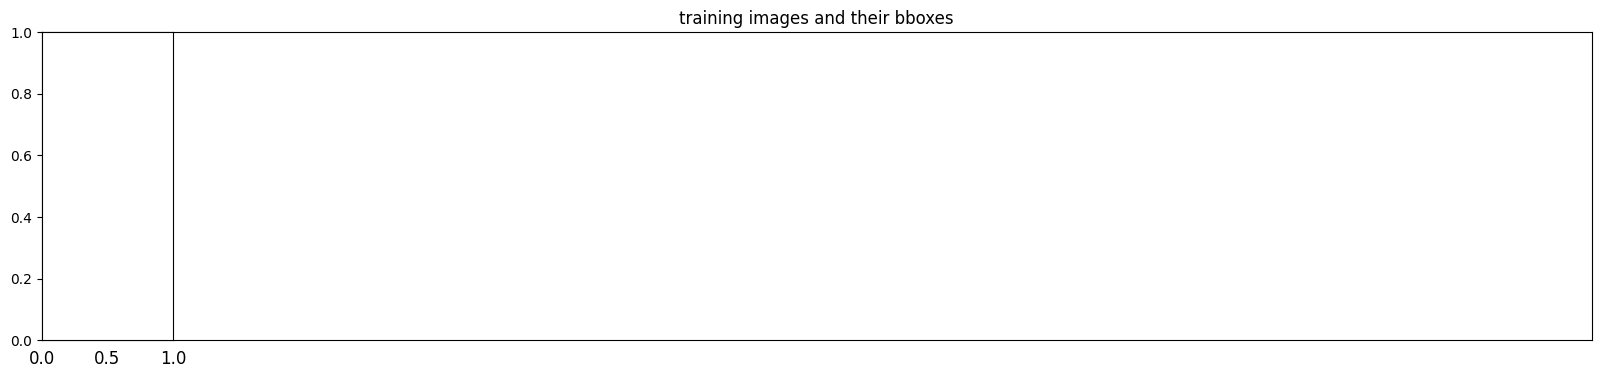

In [128]:
(visualization_training_images, visualization_training_bboxes) = convert_dataset_to_numpy_utility(visualization_training_dataset, N=10)


display_row_of_images_with_boxes_and_iou(np.array(visualization_training_images), np.array([]), visualization_training_bboxes, np.array([]), "training images and their bboxes")

In [129]:
visualization_training_dataset

<_MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4, 4), dtype=tf.float32, name=None))>

llllllllllLL Tensor("strided_slice:0", shape=(), dtype=int32)
shape of data in read_image_and_bbox: Tensor("Shape:0", shape=(4,), dtype=int32)
factor_x: Tensor("Cast:0", shape=(), dtype=float32)
factor_y: Tensor("Cast_1:0", shape=(), dtype=float32)
ds_images: [ 10   4 224 224   3]
length of images in display_row_of_images_with_boxes_and_iou: 10
bboxes to plot: [[  0.408       0.4896074   3.264       3.1593533]
 [ 14.092716   86.912     195.07285    45.696    ]
 [  0.6246246   0.82        3.1231232   2.6      ]
 [ 60.046623   44.352     148.28905   141.56801  ]]
(4, 224, 224, 3)
(4, 4)
boxes shape in draw_bounding_boxes_on_image: (4, 4)
image shape in draw_bounding_boxes_on_image: (4, 224, 224, 3)


IndexError: list index out of range

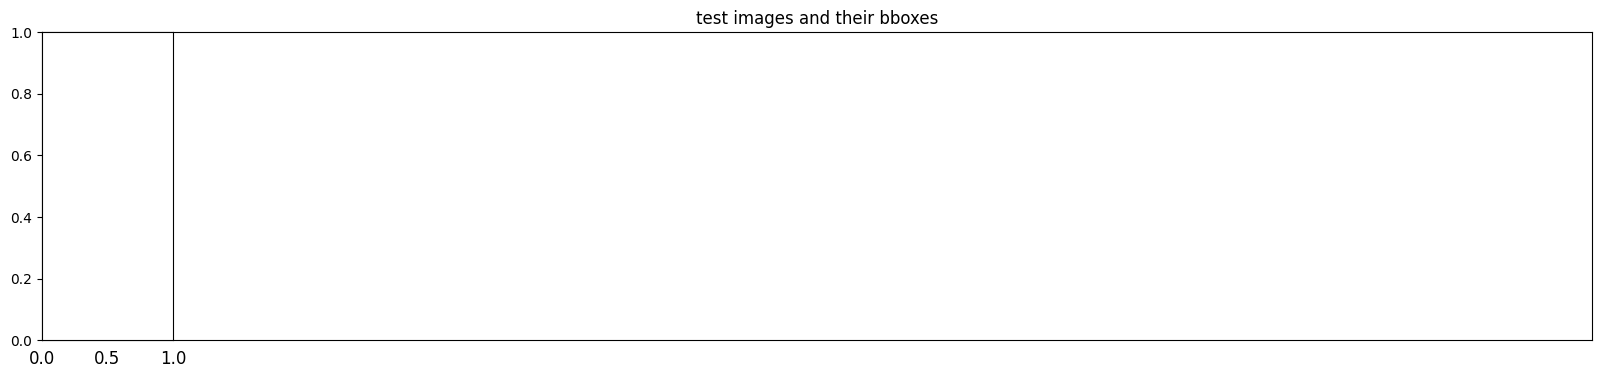

In [130]:
def get_visualization_dataset_test(dataset):
    visualization_dataset = dataset.map(read_image_and_bbox)
    return visualization_dataset

visualization_test_dataset = get_visualization_dataset_test(test_dataset)

(vis_images_test , vis_bboxes_test) = convert_dataset_to_numpy_utility(visualization_test_dataset, N=10)
display_row_of_images_with_boxes_and_iou(np.array(vis_images_test), np.array([]), np.array(vis_bboxes_test), np.array([]), "test images and their bboxes")

In [57]:
# # Funkcja do wyświetlania obrazu z bounding boxem
# def display_image_with_bbox(image, bbox):
#     # bbox jest w formacie [ymin, xmin, ymax, xmax]
#     fig, ax = plt.subplots(1)
#     ax.imshow(image)
# 
#     # Współrzędne bounding boxa
#     ymin, xmin, ymax, xmax = bbox
# 
#     # Wyrysowanie bounding boxa na obrazie
#     width = xmax - xmin
#     height = ymax - ymin
#     rect = plt.Rectangle((xmin, ymin), width, height, linewidth=2, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)
#     plt.show()
# 
# # Iteracja przez zbiór treningowy i wyświetlanie obrazów z bounding boxami
# def visualize_train_dataset(dataset, num_images=5):
#     for images, bboxes in dataset.take(num_images):  # Przerywamy po num_images
#         for img, bbox in zip(images, bboxes):
#             display_image_with_bbox(img, bbox)
# 
# # Wywołanie funkcji wizualizacji
# visualize_train_dataset(train_dataset)

In [58]:
#TODO rozwiązać problem z resize() różnych rozmiarów zdjęć. Powoduje to że nie do końca pasują bboxy do niektórych zdjęć, szczególnie tych np wysokich ale wąskich. (Tutaj kwestia wyświetlania)
#TODO zastanowić się w jaki sposób przerabiać dokładnie zdjęcia aby wrzucać je do modelu, bo tutaje już na pewno musi być dobrze zrobione bo model się źle nauczy.

In [59]:
#TODO stworzyć model uczący się z danych
#TODO stworzyć generator wrzucający dane uczące do modelu
#TODO Ewaluacja modelu na nowych zdjęciach

# Model uczący

Użyję wstępnie przetrenowanego modelu MobileNetV2. Skorzystam z gotowych wytrenowanych wag 'imagenet' które\
mogę wykorzystać w modelu MobileNetV2. Kolejne warstwy za MobileNetV2 będą warstwami które umożliwią wykonywanie\
predykcji wartości ciągłych dotyczących czterech rogów bounding boxa.\

Warstwa dopasowania wielkości zdjęcia   (UpSampling2D)\
Warstwa Feature Extractor : MobileNetV2\
Warstwy Pooling i Flatten \
Warstwy Gęste (Dense)\
Warstwa wyjściowa (4units, linear regression)\


In [60]:
def feature_extractor(inputs):
    mobilenet_model = keras.api.applications.MobileNetV2(input_shape=(224,224,3),
                                               include_top=False,
                                               weights='imagenet')
    feature_extractor = mobilenet_model(inputs)
    return feature_extractor

In [61]:
def dense_layers(features):
    
    x = GlobalAveragePooling2D()(features)
    x = Flatten()(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dense(units=512, activation='relu')(x)
    
    return x

In [62]:
def bounding_box_regression(x):
    bbox_regression = Dense(units=4, activation='linear')(x)
    
    return bbox_regression

In [63]:
def final_model(inputs):
    feature_cnn = feature_extractor(inputs)
    dense = dense_layers(feature_cnn)
    regression = bounding_box_regression(dense)
    
    bbox_output = keras.models.Model(inputs=inputs, outputs=regression)
    
    return bbox_output


In [64]:
def define_and_compile_model():
    inputs = Input(shape=(224,224,3))
    model = final_model(inputs)
    
    model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),
                  loss='mean_squared_error',
                  metrics=['accuracy'])
    
    return model

In [65]:
model = define_and_compile_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 4,062,468 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

# Train the Model

Zdefiniowanie parametrów:
+ Epochs : 20
+ Batch_size : 4
+ length_of_training_dataset : 3000
+ length_of_validation_dataset : 1000

x - touple(features and labels)


In [66]:
history = model.fit(x=train_dataset,
                    validation_data = test_dataset,
                    epochs = 20,
                    batch_size = 4)

Epoch 1/20


I0000 00:00:1726853424.356997    5872 service.cc:146] XLA service 0x7d2bac061160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726853424.357031    5872 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-09-20 19:30:24.601733: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-20 19:30:25.320032: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-09-20 19:30:25.886417: W external/local_xla/xla/service/gpu/nvptx_compiler.cc:762] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.3.107). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility

   5/1499 ━━━━━━━━━━━━━━━━━━━━ 22s 15ms/step - accuracy: 0.3658 - loss: 0.1245   

2024-09-20 19:30:39.662846: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'input_and_reduce_fusion_1', 320 bytes spill stores, 320 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion', 44 bytes spill stores, 44 bytes spill loads

I0000 00:00:1726853439.743753    5872 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1499/1499 ━━━━━━━━━━━━━━━━━━━━ 66s 29ms/step - accuracy: 0.5808 - loss: 0.0306 - val_accuracy: 0.6702 - val_loss: 0.0139
Epoch 2/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 28s 18ms/step - accuracy: 0.7042 - loss: 0.0114 - val_accuracy: 0.7639 - val_loss: 0.0078
Epoch 3/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.7264 - loss: 0.0087 - val_accuracy: 0.7736 - val_loss: 0.0068
Epoch 4/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.7622 - loss: 0.0063 - val_accuracy: 0.7901 - val_loss: 0.0056
Epoch 5/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.7783 - loss: 0.0053 - val_accuracy: 0.7920 - val_loss: 0.0053
Epoch 6/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.7857 - loss: 0.0047 - val_accuracy: 0.8081 - val_loss: 0.0047
Epoch 7/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 27s 18ms/step - accuracy: 0.8047 - loss: 0.0038 - val_accuracy: 0.8143 - val_loss: 0.0047
Epoch 8/20
1499/1499 ━━━━━━━━━━━━━━━━━━━━ 28s 19ms/step - accuracy: 0.8257 - loss: 0.00

In [77]:
loss = model.evaluate(test_dataset, steps=1000)

1000/1000 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.8591 - loss: 0.0036


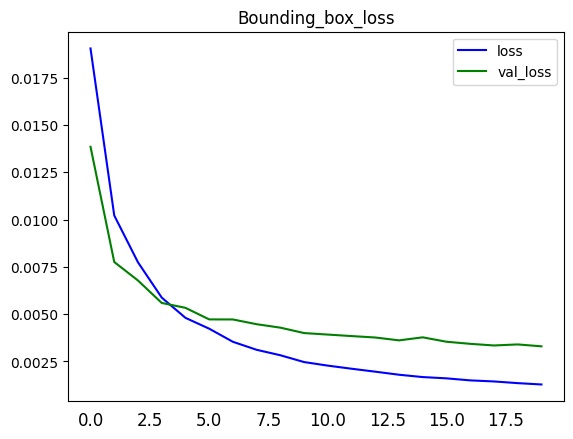

In [80]:
def display_history_metrics_after_training(metrics_name, title):
    plt.title(title)
    plt.plot(history.history[metrics_name], color='blue', label=metrics_name)
    plt.plot(history.history['val_'+metrics_name], color='green', label='val_' + metrics_name)
    plt.legend(loc='best')
    
display_history_metrics_after_training('loss','Bounding_box_loss')

# Evaluate Performance Using IoU (Intersection Over Union)

Możemy sprawdzić jak dobrze model radzi sobie z przewidywaniem bounding boxów\
dla zdjęć testowych, poprzez policzenie pokrycia rzeczywistego bboxa z\
tym przewidzianym przez model.


In [141]:
def intersection_over_union(y_true, y_pred):
    
    y_min_true, y_max_true, x_min_true, x_max_true = np.split(y_true, 4, axis=1)
    y_min_pred, y_max_pred, x_min_pred, x_max_pred = np.split(y_pred, 4, axis=1)
    
    x_min_overlap = np.maximum(x_min_true, x_min_pred)
    y_min_overlap = np.maximum(y_min_true, y_min_pred)
    x_max_overlap = np.minimum(x_max_true, x_max_pred)
    y_max_overlap = np.minimum(y_max_true, y_max_pred)
    
    pred_box_area = (y_max_pred - y_min_pred) * (x_max_pred - x_min_pred)
    true_box_area = (y_max_true - y_min_true) * (x_max_true - x_min_true)
    
    overlap_area = np.maximum((x_max_overlap - x_min_overlap) , 0) * np.maximum((y_max_overlap - y_min_overlap) , 0)
    union_area = pred_box_area + true_box_area - overlap_area
    
    smooth_value = 1e-8
    
    iou = (overlap_area + smooth_value) / (union_area + smooth_value)
    
    return iou

In [147]:
original_image, norm_image, norm_bbox = convert_dataset_to_numpy_with_original_bboxes_utility(test_dataset_prediction, N=3)

print(f'Kształt norm_image: {norm_image.shape}')  # Oczekiwane: (10, 224, 224, 3)
print(f'Kształt norm_bbox: {norm_bbox.shape}')    # Oczekiwane: (10, 4)

predicted_boxes = model.predict(norm_image.astype('float32'))

Kształt norm_image: (3, 224, 224, 3)
Kształt norm_bbox: (3, 4)
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [148]:
iou = intersection_over_union(predicted_boxes, norm_bbox)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

Number of predictions where iou > threshold(0.5): 0
Number of predictions where iou < threshold(0.5): 3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB dat

length of images in display_row_of_images_with_boxes_and_iou: 10
bboxes to plot: [[66.3776741  97.25445557 85.89173222 93.34574795]
 [ 0.18399999  0.20958083  0.53199998  0.70059879]]
(224, 224, 3)
(2, 4)
boxes shape in draw_bounding_boxes_on_image: (2, 4)
image shape in draw_bounding_boxes_on_image: (224, 224, 3)
bboxes to plot: [[66.3776741  97.25445557 85.89173222 93.34574795]
 [ 0.18399999  0.20958083  0.53199998  0.70059879]]
(224, 224, 3)
(2, 4)
boxes shape in draw_bounding_boxes_on_image: (2, 4)
image shape in draw_bounding_boxes_on_image: (224, 224, 3)
bboxes to plot: [[6.64595919e+01 9.67888641e+01 8.53851786e+01 9.35666943e+01]
 [4.61818188e-01 9.99999989e-03 4.76363644e-01 9.92000028e-01]]
(224, 224, 3)
(2, 4)
boxes shape in draw_bounding_boxes_on_image: (2, 4)
image shape in draw_bounding_boxes_on_image: (224, 224, 3)
bboxes to plot: [[66.55326557 96.77782249 85.40211487 93.45663166]
 [ 0.12012012  0.18799999  0.83183182  0.71200003]]
(224, 224, 3)
(2, 4)
boxes shape in dra

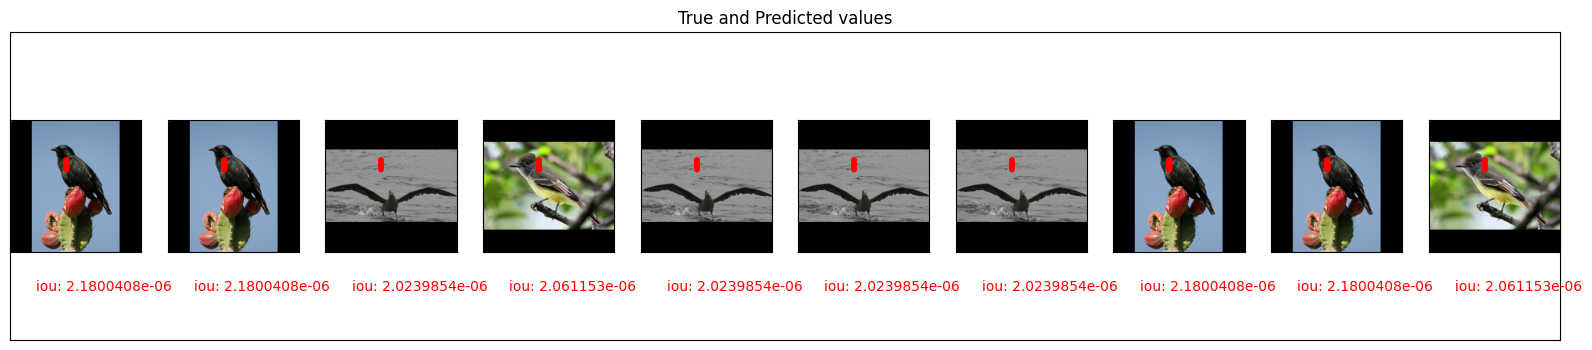

In [149]:
n = 10
indexes = np.random.choice(len(predicted_boxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_image[indexes]
display_row_of_images_with_boxes_and_iou(original_image[indexes], predicted_boxes[indexes], norm_bbox[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)